In [1]:
import pandas as pd
import numpy as np

# Mahalanobis Distance
In order to find the best parameters for our Local Outlier Factor algorithm, we will create a pipeline that will use a grid search and stratified k-fold cross-validation to ensure the best parameters and consistent results. Additionally, a search for a good threshold 
value for predicting labels will be searched for based on precision.
- Precision Equation:

precision = true positives / (true positives + false positives)




In [5]:
# Imports Mahalanobis Distance code
%run Pipeline_Code.ipynb

In [6]:
import math
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from numpy import random

# tuning is a function that splits the dataset into 4 folds
# parameters: features - feature values of dataset, labels - label values of dataset
# return: list of tuples containing fold, train data results, and test data results
def tuning(features, labels):
    res = []
    skf = StratifiedKFold(n_splits=4, shuffle=True)
    splits = skf.split(X=features, y=labels)
    
    for i, (train_index, test_index) in enumerate(splits):
        trainFeatures = np.array([features[index] for index in train_index])
        trainLabels = np.array([labels[index] for index in train_index])
        
        testFeatures = np.array([features[index] for index in test_index])
        testLabels = np.array([labels[index] for index in test_index])
        
        # Will find threshold value with training set and use the threshold value for testing set            
        trainDistances = mahalanobisDistance(trainFeatures, trainFeatures)
        threshold = findThresholdMD(trainDistances, trainLabels)
        predictedTrainLabels = predictMD(threshold, trainFeatures)
        
        predictedTestLabels = predictMD(threshold, testFeatures)

        res.append((i, (predictedTrainLabels, trainLabels), (predictedTestLabels, testLabels)))
        
    return res
   

    # runPipeline loads specified dataset in and passes the dataset into another function which will run ML classifiers on the dataset
    # return: None, prints out results from classifiers which are run through k-fold cross-validation and hyperparameter tuning
def pipeline(dataSetName):
    if dataSetName == "credit_card":
        #file path to credit card csv file
        file_path = os.path.join(os.path.expanduser("~"), "Desktop", "archive(2)", "creditcard.csv")
        df = pd.read_csv(file_path) #read csv file as pandas object
        
        #Randomly gets 80000 examples out of the 284807 available examples
        randomIndices = random.randint(284807, size=(80000))
        data = df.take(randomIndices)

        data = np.array(data)
        
        fraud_instances = []
        for i in range(len(data)):
            if data[i][-1] == 1:
                fraud_instances.append(i)
        
        #prints out the number of fraud instances so we can ensure enough positive examples are in the dataset
        print("Number of positive examples: ", len(fraud_instances))
        
        # Gets features
        features = np.array([arr[:-1] for arr in data])
        
        #Gets labels
        labels = np.array(df["Class"][randomIndices])
    else: 
        print("Invalid data set, use one of the following data sets:")
        return
    
    results = tuning(features, labels)
    return results
    # print("Mahalanobis Distance Test Results:")
    # print("--------------")
    # print("Fold, Training Set Matrix Data, Testing Matrix Data")
    # for fold in range(4):
        # print(fold, results[fold][1], results[fold][2])

In [7]:
results = pipeline("credit_card")

Number of positive examples:  150


In [16]:
import matplotlib.pyplot as plt
import itertools
%matplotlib widget
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
print("Mahalanobis Distance Test Results:")
print("--------------")
print("Fold, Training Set Matrix Data, Testing Matrix Data")
for fold in range(4):
    print(fold+1)
    print("Training")
    print(matrixScoresMD(confusionMatrixMD(results[fold][1][1], results[fold][1][0]), "precision"))
    print(matrixScoresMD(confusionMatrixMD(results[fold][1][1], results[fold][1][0]), "recall"))
    print(matrixScoresMD(confusionMatrixMD(results[fold][1][1], results[fold][1][0]), "f1score"))
    
    print("Testing")
    print(matrixScoresMD(confusionMatrixMD(results[fold][2][1], results[fold][2][0]), "precision"))
    print(matrixScoresMD(confusionMatrixMD(results[fold][2][1], results[fold][2][0]), "recall"))
    print(matrixScoresMD(confusionMatrixMD(results[fold][2][1], results[fold][2][0]), "f1score"))

Mahalanobis Distance Test Results:
--------------
Fold, Training Set Matrix Data, Testing Matrix Data
1
Training
0.37777777777777777
0.1504424778761062
0.21518987341772153
Testing
0.3888888888888889
0.1891891891891892
0.2545454545454546
2
Training
0.36363636363636365
0.21238938053097345
0.2681564245810056
Testing
0.21052631578947367
0.10810810810810811
0.14285714285714288
3
Training
0.3902439024390244
0.14285714285714285
0.2091503267973856
Testing
0.125
0.02631578947368421
0.043478260869565216
4
Training
0.42
0.1875
0.2592592592592593
Testing
0.2222222222222222
0.10526315789473684
0.14285714285714285


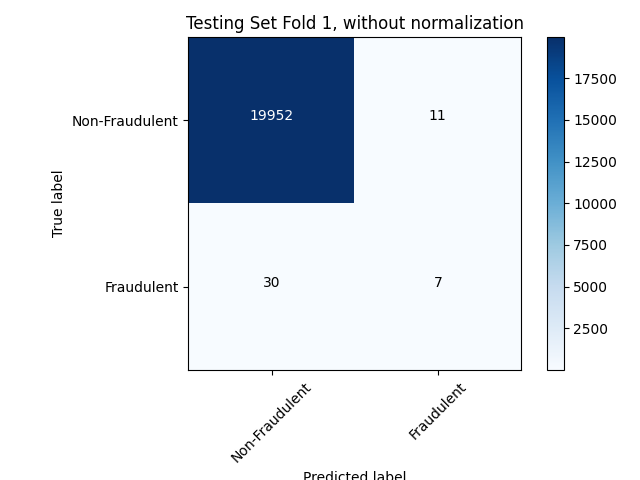

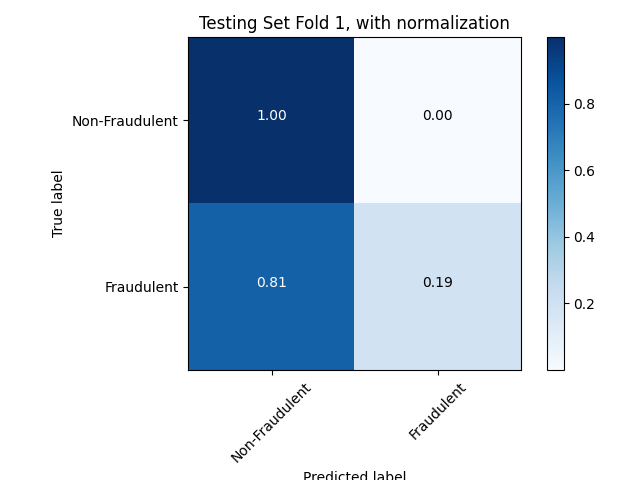

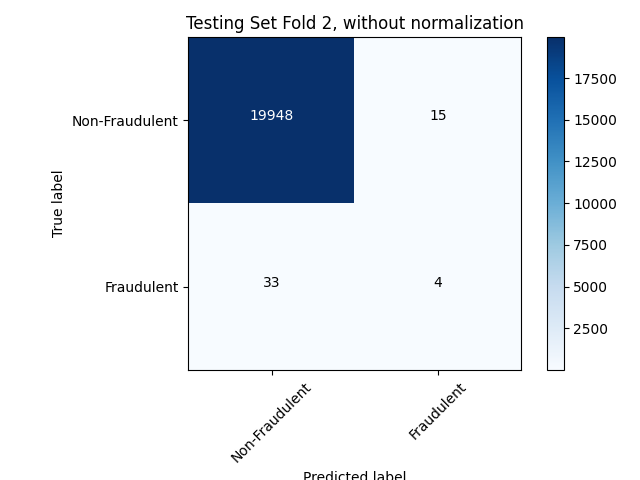

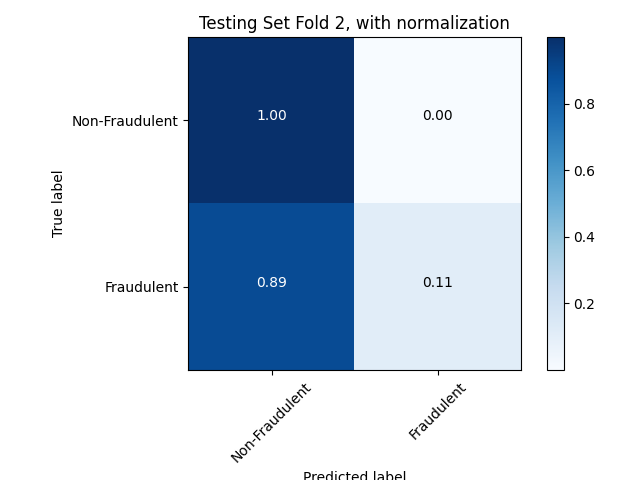

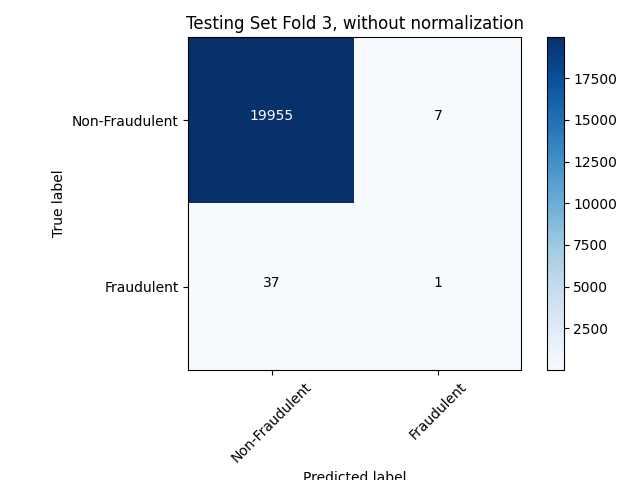

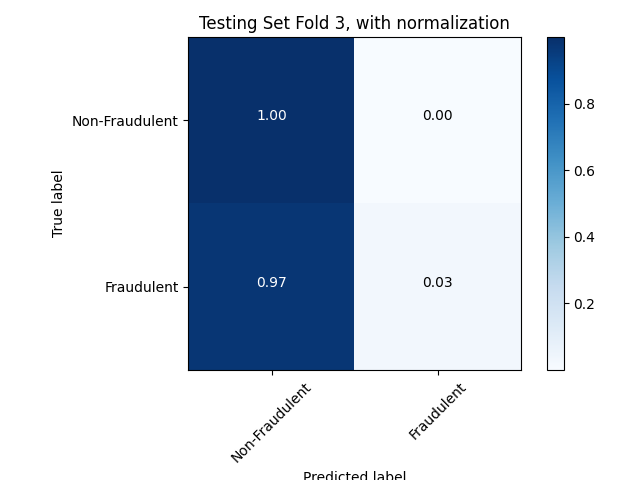

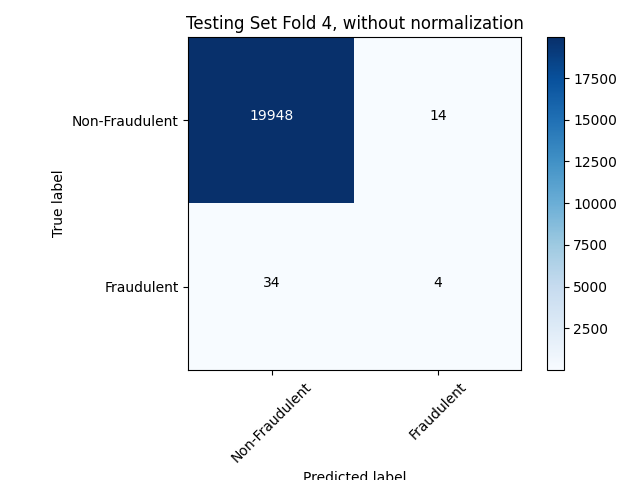

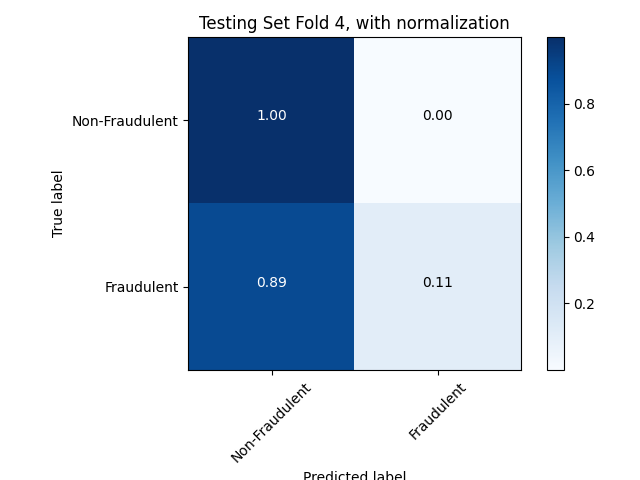

In [20]:
for i in range(len(results)):
    cm = confusion_matrix(y_true=results[i][2][1], y_pred=results[i][2][0])
    plt.figure()
    title1 = "Testing Set Fold " + str(i+1) + ", without normalization"
    plot_confusion_matrix(cm, ["Non-Fraudulent", "Fraudulent"], normalize=False, title=title1)
    title2 = "Testing Set Fold " + str(i+1) + ", with normalization"
    plt.figure()
    plot_confusion_matrix(cm, ["Non-Fraudulent", "Fraudulent"], normalize=True, title=title2)